# Generate Pairs

In [1]:
%load_ext autoreload
%autoreload 2
from utils import dpo_dependencies
from utils import base_dependencies
import random
import pandas as pd
import numpy as np
import shutil
import os
import json
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

c:\Users\HP\anaconda3\envs\thesis_3_9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Visualize Stats

In [2]:
dpo_possibilities_orig = pd.DataFrame(base_dependencies.load_jsonl('outputs/dpo/tmp.jsonl'))

remap_model_names = {
    'sft_disco_llama8b_checkpoint2800': 'Disco Llama8B',
    'sft_llama8b_checkpoint2400': 'Llama8B',
    'sft_leolm_mistral7b_checkpoint1600': 'LeoLM Mistral 7B'
}
dpo_possibilities_orig['model'] = dpo_possibilities_orig['model'].map(remap_model_names)
dpo_possibilities_orig['inf_params'] = 'p' + dpo_possibilities_orig['filename'].str.split("_p").str[1].str.split("_").str[0]

def replace_with_key_of_largest(d):
    largest = max(d, key=d.get)
    if d[largest] >= 0.9 and largest == 'entailment':
        return 'strong entailment'
    return 'neutral, contradiction, or weak entailment'

#dpo_possibilities_orig['nli'] = dpo_possibilities_orig['original_simplification_entailment'].apply(replace_with_key_of_largest)
#dpo_possibilities_orig['entailment'] = dpo_possibilities_orig['original_simplification_entailment'].apply(lambda x: x['entailment'])
#dpo_possibilities_orig['neutral'] = dpo_possibilities_orig['original_simplification_entailment'].apply(lambda x: x['neutral'])
#dpo_possibilities_orig['contradiction'] = dpo_possibilities_orig['original_simplification_entailment'].apply(lambda x: x['contradiction'])
dpo_possibilities_orig['orig_simp_comp_diff'] = dpo_possibilities_orig['original_complexity'] - dpo_possibilities_orig['simplification_complexity']
dpo_possibilities_orig['rouge'] = base_dependencies.pull_rouge(list(dpo_possibilities_orig['original']), list(dpo_possibilities_orig['simplification']))
for var in ['rouge1', 'rouge2', 'rougeL']:
    dpo_possibilities_orig[f'o2s_{var}_f'] = dpo_possibilities_orig['rouge'].apply(lambda x: x[var][2])
dpo_possibilities_orig = dpo_possibilities_orig.drop(columns=['rouge'])

# filter based on length
pre_len = len(dpo_possibilities_orig)
dpo_possibilities_orig['wc'] = base_dependencies.wcs(dpo_possibilities_orig['simplification'])
dpo_possibilities = dpo_possibilities_orig[dpo_possibilities_orig['wc'] < 30].copy()
print(f'dropped {pre_len - len(dpo_possibilities)} simplifications due to length')

# filter based on ends with Number. (this is typically a date which has been innapropriately spliced)
pre_date_filter = len(dpo_possibilities)
german_months = r'(?i)januar|februar|märz|april|mai|juni|juli|august|september|oktober|november|dezember'
dpo_possibilities = dpo_possibilities[~dpo_possibilities['original'].str.lower().str.match(rf'^({german_months})\b', na=False)]
dpo_possibilities = dpo_possibilities[~dpo_possibilities['original'].str.contains(r'\d\.$', na=False)]
print(f'dropped {len(dpo_possibilities)} due to innapropriate date split')

# filter based on ends with innapropriate abbreviation
pre_abbrev_filter = len(dpo_possibilities)
dpo_possibilities = dpo_possibilities[~dpo_possibilities['original'].str.endswith('bzw.')]
dpo_possibilities = dpo_possibilities[~dpo_possibilities['original'].str.endswith('etc.')]
print(f'dropped {len(dpo_possibilities)} due to innapropriate abbrev. ending')

# filter based on metacommentary
dpo_possibilities.loc[:, 'mcf'] = dpo_possibilities['simplification'].apply(dpo_dependencies.meta_commentary_filter)
dpo_possibilities['mcf'].value_counts()
pre_meta = len(dpo_possibilities)
dpo_possibilities = dpo_possibilities[dpo_possibilities['mcf'] == '']
dpo_possibilities = dpo_possibilities.drop(columns='mcf')
print(f'dropped {pre_meta - len(dpo_possibilities)} simplifications due to meta commentary')

# filter based on cossim
pre_cossim = len(dpo_possibilities)
dpo_possibilities = dpo_possibilities[dpo_possibilities['original_simplification_cossim'] > 0.5]
# dpo_possibilities = dpo_possibilities[dpo_possibilities['original_simplification_cossim'] < 0.9]
dpo_possibilities = dpo_possibilities.reset_index(drop=True)
print(f'dropped {pre_cossim - len(dpo_possibilities)} simplifications due to orig->simp cossim < 0.5 or > 0.9')

# filter based on perplexity
pre_perplexity = len(dpo_possibilities)
dpo_possibilities = dpo_possibilities[dpo_possibilities['perplexity'] < 15]
print(f'dropped {pre_perplexity - len(dpo_possibilities)} simplifications due to high perplexity')

# filter based on rouge (0.9 is lighter than the 0.8 from SFT)
dpo_possibilities = dpo_possibilities[dpo_possibilities['o2s_rouge1_f'] < 0.95]
dpo_possibilities = dpo_possibilities[dpo_possibilities['o2s_rouge2_f'] < 0.9]
dpo_possibilities = dpo_possibilities[dpo_possibilities['o2s_rougeL_f'] < 0.9]

# find unique pairings
random.seed(5)
orig_level_cols = ['model', 'orig_id', 'prompt', 'original', 'original_complexity'] # 'original_english', 
unique_simplification_pairs  = []
for key, group in dpo_possibilities.groupby(orig_level_cols):
    simplifications = group[['simplification', 'perplexity', 'original_simplification_cossim', 'wc', 'simplification_complexity', 'o2s_rouge1_f', 'o2s_rouge2_f', 'o2s_rougeL_f', 'inf_params']] #'nli', 'entailment', 'neutral', 'contradiction', 'simplification_english', 
    pairs = list(combinations(simplifications.to_dict('records'), 2))
    for pair in pairs:
        if random.random() < 0.5:
            lefthand_obs, righthand_obs = pair[0], pair[1]
        else:
            lefthand_obs, righthand_obs = pair[1], pair[0]

        unique_simplification_pairs.append({
            **dict(zip(orig_level_cols, key)),
            'simp1': lefthand_obs['simplification'],
            'simp2': righthand_obs['simplification'],
            'wc1': lefthand_obs['wc'],
            'wc2': righthand_obs['wc'],
            'perp1': lefthand_obs['perplexity'],
            'perp2': righthand_obs['perplexity'],
            #'simp_eng1': lefthand_obs['simplification_english'],
            #'simp_eng2': righthand_obs['simplification_english'],
            'cossim1': lefthand_obs['original_simplification_cossim'],
            'cossim2': righthand_obs['original_simplification_cossim'],
            #'nli1': lefthand_obs['nli'],
            #'nli2': righthand_obs['nli'],
            #'entail1': lefthand_obs['entailment'],
            #'entail2': righthand_obs['entailment'],
            #'neutral1':lefthand_obs['neutral'],
            #'neutral2':righthand_obs['neutral'],
            #'contrad1':lefthand_obs['contradiction'],
            #'contrad2':righthand_obs['contradiction'],
            'simp_comp1':lefthand_obs['simplification_complexity'],
            'simp_comp2':righthand_obs['simplification_complexity'],
            'o2s1_rouge1_f':lefthand_obs['o2s_rouge1_f'],
            'o2s2_rouge1_f':righthand_obs['o2s_rouge1_f'],
            'o2s1_rouge2_f':lefthand_obs['o2s_rouge2_f'],
            'o2s2_rouge2_f':righthand_obs['o2s_rouge2_f'],
            'o2s1_rougeL_f':lefthand_obs['o2s_rougeL_f'],
            'o2s2_rougeL_f':righthand_obs['o2s_rougeL_f'],
            'inf_params1':lefthand_obs['inf_params'],
            'inf_params2':righthand_obs['inf_params'],
        })
        
unique_simplification_pairs_orig = pd.DataFrame(unique_simplification_pairs)

unique_simplification_pairs_orig['eops'] = unique_simplification_pairs_orig.apply(lambda row: dpo_dependencies.eops_count(row['simp1'], row['simp2']), axis=1)
unique_simplification_pairs_orig['wc_diff'] = unique_simplification_pairs_orig['wc1'] - unique_simplification_pairs_orig['wc2']
unique_simplification_pairs_orig['perplexity_diff'] = unique_simplification_pairs_orig['perp1'] - unique_simplification_pairs_orig['perp2']
unique_simplification_pairs_orig['complexity_diff'] = unique_simplification_pairs_orig['simp_comp1'] - unique_simplification_pairs_orig['simp_comp2']
unique_simplification_pairs_orig['rouge_s2s'] = base_dependencies.pull_rouge(list(unique_simplification_pairs_orig['simp1']), list(unique_simplification_pairs_orig['simp2']))
for var in ['rouge1', 'rouge2', 'rougeL']:
    unique_simplification_pairs_orig[f's2s_{var}_f'] = unique_simplification_pairs_orig['rouge_s2s'].apply(lambda x: x[var][2])
unique_simplification_pairs_orig = unique_simplification_pairs_orig.drop(columns=['rouge_s2s'])

# keep the ones that have already been approved
manual_feedback = dpo_dependencies.previous_manual_feedback_position_agnostic()
manual_feedback_wins_only = manual_feedback[manual_feedback['manual_feedback'] == 'w']
unique_simplification_pairs_orig = pd.merge(left=unique_simplification_pairs_orig, right=manual_feedback_wins_only, on=['original', 'simp1', 'simp2'], how='left', validate = 'm:1')
print(unique_simplification_pairs_orig['manual_feedback'].value_counts())

# filter based on edit operations
pre_eops = len(unique_simplification_pairs_orig)
unique_simplification_pairs = unique_simplification_pairs_orig[(unique_simplification_pairs_orig['eops'] > 2) & (unique_simplification_pairs_orig['eops'] < 30)].reset_index(drop=True)
print(f'dropped {pre_eops - len(unique_simplification_pairs)} simplification pairs due to extreme edit ops')

# filter based on length difference
pre_len_diff = len(unique_simplification_pairs)
unique_simplification_pairs = unique_simplification_pairs[np.abs(unique_simplification_pairs['wc_diff']) < 100].reset_index(drop=True)
print(f'dropped {pre_len_diff - len(unique_simplification_pairs)} for too large length difference')

# filter based on perplexity difference
pre_perp_diff = len(unique_simplification_pairs)
unique_simplification_pairs = unique_simplification_pairs[(np.abs(unique_simplification_pairs['perplexity_diff']) > 0)].reset_index(drop=True)
print(f'dropped {pre_perp_diff - len(unique_simplification_pairs)} for too low perplexity difference')

# filter based on rouge difference
pre_rouge_diff = len(unique_simplification_pairs)
#unique_simplification_pairs = unique_simplification_pairs[(np.abs(unique_simplification_pairs['s2s_rouge1_f']) < 0.95)].reset_index(drop=True)
#unique_simplification_pairs = unique_simplification_pairs[(np.abs(unique_simplification_pairs['s2s_rouge1_f']) < 0.95)].reset_index(drop=True)
#unique_simplification_pairs = unique_simplification_pairs[(np.abs(unique_simplification_pairs['s2s_rouge1_f']) < 0.95)].reset_index(drop=True)
print(f'dropped {pre_perp_diff - len(unique_simplification_pairs)} for too high rouge similarity')

# create id column
unique_simplification_pairs['simp_pair_id'] = (
    'pid_'+
    unique_simplification_pairs['orig_id'].str.replace('uid_', '').str.split('_').str[0] +
    unique_simplification_pairs.index.astype(str)
)

scale = 1.5
unique_simplification_pairs['sampling_weight'] = unique_simplification_pairs.groupby('model')['perplexity_diff'].transform(
    lambda x: np.exp(-0.5 * ((x - x.mean()) ** 2) / (scale*x.var()))
)
#cumulative_store_manual_feedback = base_dependencies.load_jsonl(f'outputs/dpo/cumulative_stores/manual_feedback.jsonl')
#previous_manual_feedback = pd.DataFrame(cumulative_store_manual_feedback)
#unique_simplification_pairs = pd.merge(unique_simplification_pairs, previous_manual_feedback, how='left', on=['original', 'simp1', 'simp2'], validate='m:1', indicator=True)
#unique_simplification_pairs['manual_feedback'] = unique_simplification_pairs['manual_feedback'].fillna('u')
#unique_simplification_pairs.head()

#unique_simplification_pairs.to_json('outputs/dpo/possible_pairs.jsonl', orient='records', lines=True)

dropped 44089 simplifications due to length
dropped 334128 due to innapropriate date split
dropped 332764 due to innapropriate abbrev. ending
dropped 207 simplifications due to meta commentary
dropped 49032 simplifications due to orig->simp cossim < 0.5 or > 0.9
dropped 3407 simplifications due to high perplexity
Series([], Name: manual_feedback, dtype: int64)
dropped 90531 simplification pairs due to extreme edit ops
dropped 0 for too large length difference
dropped 0 for too low perplexity difference
dropped 0 for too high rouge similarity


In [3]:
len(unique_simplification_pairs)

1863188

In [4]:
unique_simplification_pairs = unique_simplification_pairs[(np.abs(unique_simplification_pairs['s2s_rouge1_f']) < 0.90)].reset_index(drop=True)
unique_simplification_pairs = unique_simplification_pairs[(np.abs(unique_simplification_pairs['s2s_rouge2_f']) < 0.90)].reset_index(drop=True)
unique_simplification_pairs = unique_simplification_pairs[(np.abs(unique_simplification_pairs['s2s_rougeL_f']) < 0.90)].reset_index(drop=True)
#usp.to_json('outputs/dpo/possible_pairs_20250209/possible_pairs.jsonl', orient='records', lines=True)

In [5]:
team_pairs, team_skips = dpo_dependencies.load_pair_creation_files('team_pairs_20250220')
simp_level_approved = pd.concat([team_pairs[['original','simp1']].rename(columns={'simp1':'simplification'}), team_pairs[['original','simp2']].rename(columns={'simp2':'simplification'})]).reset_index(drop=True)
team_pairs = team_pairs.drop_duplicates(keep='last')
team_pairs = team_pairs[['original', 'simp1', 'simp2']]
team_pairs_copy = team_pairs.copy()
team_pairs_copy['simp1'] = team_pairs_copy['simp2']
team_pairs_copy['simp2'] = team_pairs_copy['simp1']
manual_feedback_wins_only = pd.concat([team_pairs, team_pairs_copy]).reset_index(drop=True)

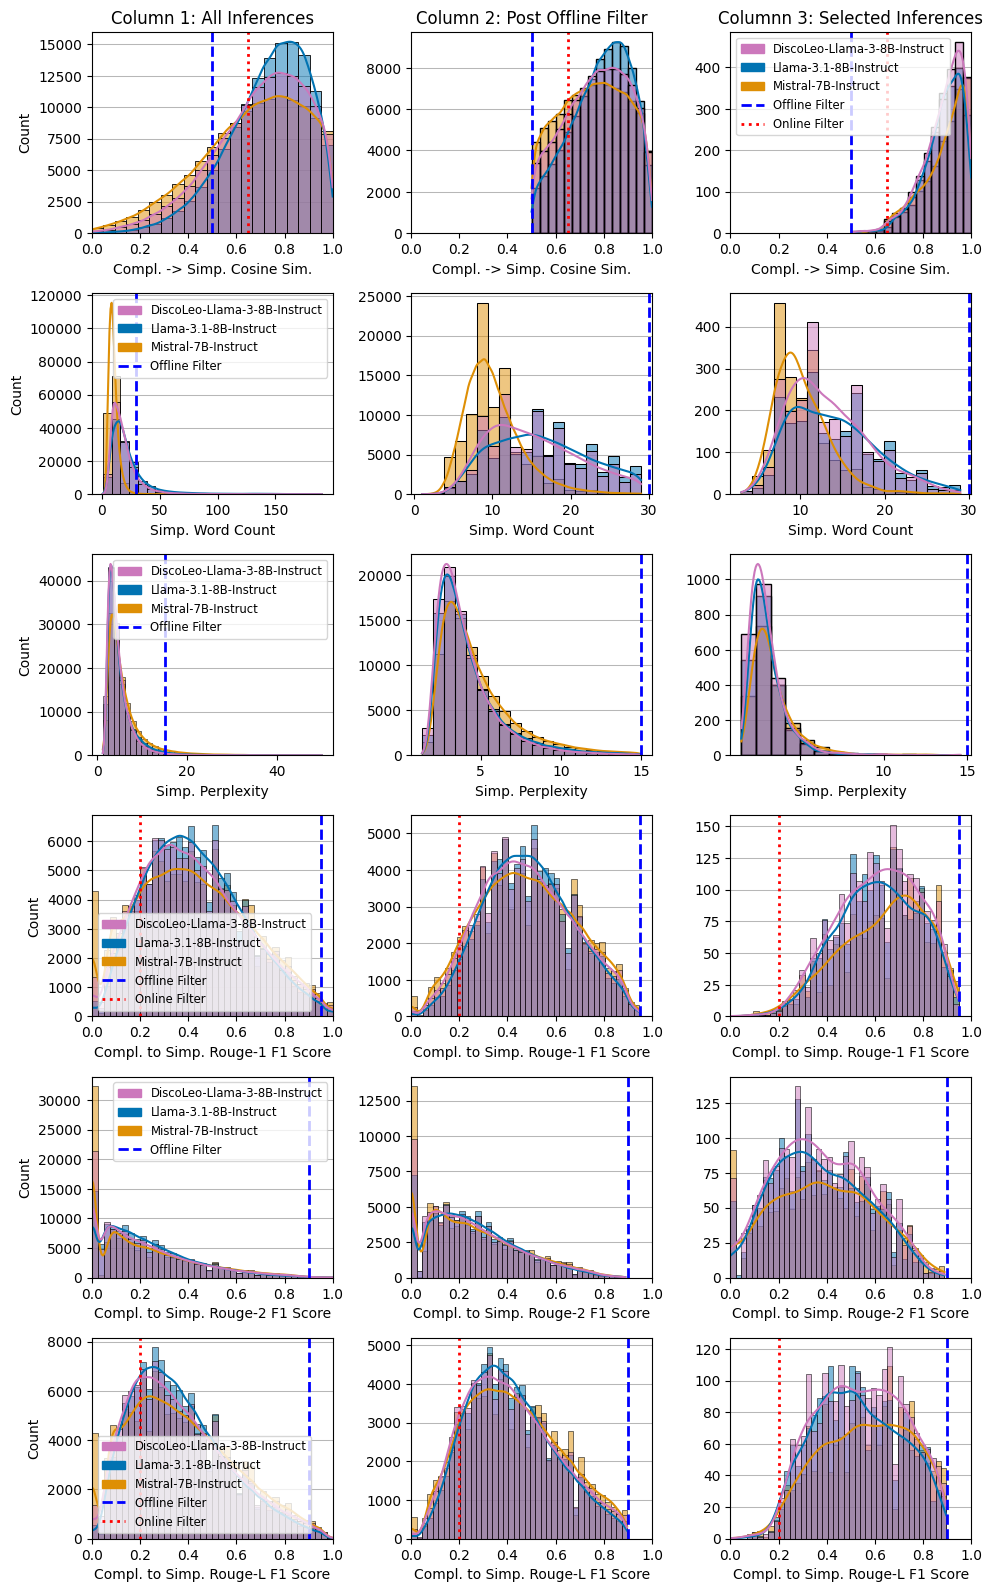

In [6]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, axes = plt.subplots(6, 3, figsize=(10, 16))

dpo_possibilities_approved = pd.merge(left=dpo_possibilities, right=simp_level_approved, how='right', on=['original', 'simplification'])
unique_simplification_pairs_approved = pd.merge(left=unique_simplification_pairs, right=manual_feedback_wins_only, how='right', on=['original', 'simp1', 'simp2'])

def attach_to_grid(df, x_column, x_coord, y_coord, bins, title, x_label, y_label, bwadjust=1):
    model_order = ['Disco Llama8B', 'Llama8B', 'LeoLM Mistral 7B']
    palette = {model: base_dependencies.return_model_color(model.lower()) for model in model_order}
    sns.histplot(data = df, x = x_column, hue='model', hue_order = model_order, kde=True, kde_kws={'bw_adjust': bwadjust}, bins = bins, alpha = 0.5, ax=axes[x_coord, y_coord], palette=palette)
    if x_column == 'original_simplification_cossim':
        axes[x_coord, y_coord].set_xlim(0, 1)
        axes[x_coord, y_coord].axvline(x=0.5, color='blue', linestyle='--', linewidth=2)
        axes[x_coord, y_coord].axvline(x=0.65, color='red', linestyle=':', linewidth=2)
    if x_column == 'wc':
        axes[x_coord, y_coord].axvline(x=30, color='blue', linestyle='--', linewidth=2)
    if x_column == 'perplexity':
        axes[x_coord, y_coord].axvline(x=15, color='blue', linestyle='--', linewidth=2)
    if x_column == 'o2s_rouge1_f':
        axes[x_coord, y_coord].axvline(x=0.95, color='blue', linestyle='--', linewidth=2)
        axes[x_coord, y_coord].axvline(x=0.2, color='red', linestyle=':', linewidth=2)
    if x_column == 'o2s_rouge2_f':
        axes[x_coord, y_coord].axvline(x=0.9, color='blue', linestyle='--', linewidth=2)
    if x_column == 'o2s_rougeL_f':
        axes[x_coord, y_coord].axvline(x=0.9, color='blue', linestyle='--', linewidth=2)
        axes[x_coord, y_coord].axvline(x=0.2, color='red', linestyle=':', linewidth=2)
    if x_column == 's2s_rouge1_f':
        axes[x_coord, y_coord].axvline(x=0.8, color='blue', linestyle='--', linewidth=2)
    if x_column == 's2s_rouge2_f':
        axes[x_coord, y_coord].axvline(x=0.8, color='blue', linestyle='--', linewidth=2)
    if x_column == 's2s_rougeL_f':
        axes[x_coord, y_coord].axvline(x=0.8, color='blue', linestyle='--', linewidth=2)
    if 'rouge' in x_column:
        axes[x_coord, y_coord].set_xlim(0, 1)

    axes[x_coord, y_coord].set_title(title)
    axes[x_coord, y_coord].set_xlabel(x_label)
    axes[x_coord, y_coord].set_ylabel(y_label)

    axes[x_coord, y_coord].grid(axis='y', linestyle='-', linewidth=0.75, alpha=0.9)
    axes[x_coord, y_coord].set_axisbelow(True)
    #if 'wc' in x_column or 'perplexity' in x_column: 
    #    axes[x_coord, y_coord].set_xscale("log")

attach_to_grid(dpo_possibilities_orig, 'original_simplification_cossim', 0, 0, 25, 'Column 1: All Inferences', 'Compl. -> Simp. Cosine Sim.', 'Count')
attach_to_grid(dpo_possibilities, 'original_simplification_cossim', 0, 1, 15, 'Column 2: Post Offline Filter', 'Compl. -> Simp. Cosine Sim.', '')
attach_to_grid(dpo_possibilities_approved, 'original_simplification_cossim', 0, 2, 15, 'Columnn 3: Selected Inferences', 'Compl. -> Simp. Cosine Sim.', '')

attach_to_grid(dpo_possibilities_orig, 'wc', 1, 0, 25, '', 'Simp. Word Count', 'Count')
attach_to_grid(dpo_possibilities, 'wc', 1, 1, 20, '', 'Simp. Word Count', '', bwadjust=1.5)
attach_to_grid(dpo_possibilities_approved, 'wc', 1, 2, 20, '', 'Simp. Word Count', '')

attach_to_grid(dpo_possibilities_orig[dpo_possibilities_orig['perplexity'] < 50], 'perplexity', 2, 0, 40, '', 'Simp. Perplexity', 'Count')
attach_to_grid(dpo_possibilities, 'perplexity', 2, 1, 20, '', 'Simp. Perplexity', '')
attach_to_grid(dpo_possibilities_approved, 'perplexity', 2, 2, 15, '', 'Simp. Perplexity', '')

attach_to_grid(dpo_possibilities_orig, 'o2s_rouge1_f', 3, 0, 40, '', 'Compl. to Simp. Rouge-1 F1 Score', 'Count')
attach_to_grid(dpo_possibilities, 'o2s_rouge1_f', 3, 1, 40, '', 'Compl. to Simp. Rouge-1 F1 Score', '')
attach_to_grid(dpo_possibilities_approved, 'o2s_rouge1_f', 3, 2, 40, '', 'Compl. to Simp. Rouge-1 F1 Score', '')

attach_to_grid(dpo_possibilities_orig, 'o2s_rouge2_f', 4, 0, 40, '', 'Compl. to Simp. Rouge-2 F1 Score', 'Count')
attach_to_grid(dpo_possibilities, 'o2s_rouge2_f', 4, 1, 40, '', 'Compl. to Simp. Rouge-2 F1 Score', '')
attach_to_grid(dpo_possibilities_approved, 'o2s_rouge2_f', 4, 2, 40, '', 'Compl. to Simp. Rouge-2 F1 Score', '')

attach_to_grid(dpo_possibilities_orig, 'o2s_rougeL_f', 5, 0, 40, '', 'Compl. to Simp. Rouge-L F1 Score', 'Count')
attach_to_grid(dpo_possibilities, 'o2s_rougeL_f', 5, 1, 40, '', 'Compl. to Simp. Rouge-L F1 Score', '')
attach_to_grid(dpo_possibilities_approved, 'o2s_rougeL_f', 5, 2, 40, '', 'Compl. to Simp. Rouge-L F1 Score', '')

#attach_to_grid(dpo_possibilities_orig, 'orig_simp_comp_diff', 6, 0, 40, 'Orig. Complexity', 'Complexity (orig)', '')
#attach_to_grid(dpo_possibilities, 'orig_simp_comp_diff', 6, 1, 40, 'Orig. Complexity', 'Complexity (orig)', '')
#attach_to_grid(dpo_possibilities_approved, 'orig_simp_comp_diff', 6, 2, 40, 'Orig. Complexity', 'Complexity (orig)', '')

#attach_to_grid(dpo_possibilities_orig, 'orig_simp_comp_diff', 7, 0, 40, 'Orig. - Simp. Complexity', 'Complexity Differential (orig)', '')
#attach_to_grid(dpo_possibilities, 'orig_simp_comp_diff', 7, 1, 40, 'Orig. - Simp. Complexity', 'Complexity Differential (orig)', '')
#attach_to_grid(dpo_possibilities_approved, 'orig_simp_comp_diff', 7, 2, 40, 'Orig. - Simp. Complexity', 'Complexity Differential (orig)', '')

for ax in axes[:, 1:3].flat:
    ax.legend_.remove()

custom_legend = [
    Patch(color=base_dependencies.return_model_color('disco'), label=base_dependencies.return_proper_model_name('disco')),
    Patch(color=base_dependencies.return_model_color('llama'), label=base_dependencies.return_proper_model_name('llama')),
    Patch(color=base_dependencies.return_model_color('leolm'), label=base_dependencies.return_proper_model_name('mistral')),
    Line2D([0], [0], color='blue', linestyle='--', linewidth=2, label='Offline Filter'),
    Line2D([0], [0], color='red', linestyle=':', linewidth=2, label='Online Filter')
]

custom_legend2 = [
    Patch(color=base_dependencies.return_model_color('disco'), label=base_dependencies.return_proper_model_name('disco')),
    Patch(color=base_dependencies.return_model_color('llama'), label=base_dependencies.return_proper_model_name('llama')),
    Patch(color=base_dependencies.return_model_color('leolm'), label=base_dependencies.return_proper_model_name('mistral')),
    Line2D([0], [0], color='blue', linestyle='--', linewidth=2, label='Offline Filter')
]

axes[0, 0].legend_.remove()
axes[0, 2].legend(handles=custom_legend, loc='upper left', fontsize='small')
axes[1, 0].legend(handles=custom_legend2, loc='upper right', fontsize='small')
axes[2, 0].legend(handles=custom_legend2, loc='upper right', fontsize='small')
axes[3, 0].legend(handles=custom_legend, loc='lower left', fontsize='small')
axes[4, 0].legend(handles=custom_legend2, loc='upper right', fontsize='small')
axes[5, 0].legend(handles=custom_legend, loc='lower left', fontsize='small')

plt.tight_layout(pad=1.0)

plt.savefig('figures/prefpair_creation_infstats_c2s.png', dpi=800)

plt.show()

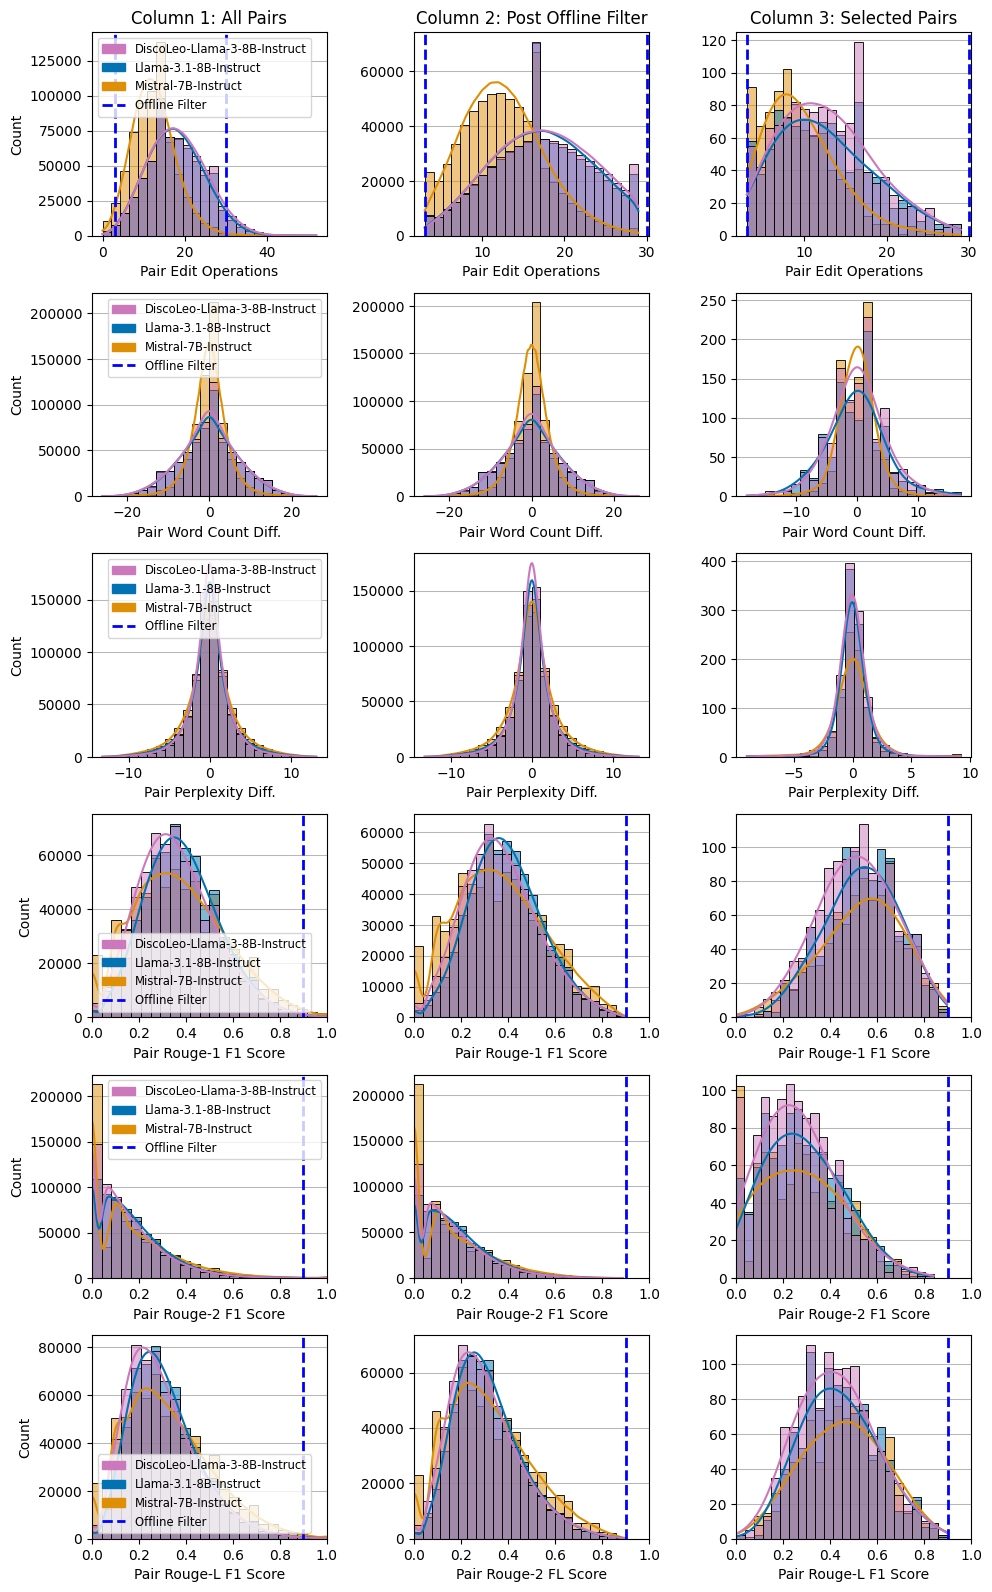

In [7]:
fig, axes = plt.subplots(6, 3, figsize=(10, 16))

def attach_to_grid(df, x_column, x_coord, y_coord, bins, title, x_label, y_label, bwadjust=1.75):
    model_order = ['Disco Llama8B', 'Llama8B', 'LeoLM Mistral 7B']
    palette = {model: base_dependencies.return_model_color(model.lower()) for model in model_order}
    sns.histplot(data = df, x = x_column, hue='model', hue_order = model_order, kde=True, kde_kws={'bw_adjust': bwadjust}, bins = bins, alpha = 0.5, ax=axes[x_coord, y_coord], palette=palette)
    if x_column == 'original_simplification_cossim':
        axes[x_coord, y_coord].set_xlim(0, 1)
        axes[x_coord, y_coord].axvline(x=0.5, color='blue', linestyle='--', linewidth=2)
        axes[x_coord, y_coord].axvline(x=0.65, color='red', linestyle='--', linewidth=2)
    if x_column == 'wc':
        axes[x_coord, y_coord].axvline(x=30, color='blue', linestyle='--', linewidth=2)
    if x_column == 'perplexity':
        axes[x_coord, y_coord].axvline(x=15, color='blue', linestyle='--', linewidth=2)
    if x_column == 's2s_rouge1_f':
        axes[x_coord, y_coord].axvline(x=0.9, color='blue', linestyle='--', linewidth=2)
    if x_column == 's2s_rouge2_f':
        axes[x_coord, y_coord].axvline(x=0.9, color='blue', linestyle='--', linewidth=2)
    if x_column == 's2s_rougeL_f':
        axes[x_coord, y_coord].axvline(x=0.9, color='blue', linestyle='--', linewidth=2)
    if x_column == 'eops':
        axes[x_coord, y_coord].axvline(x=3, color='blue', linestyle='--', linewidth=2)
        axes[x_coord, y_coord].axvline(x=30, color='blue', linestyle='--', linewidth=2)
    #if x_column == 's2s_rouge1_f':
    #    axes[x_coord, y_coord].axvline(x=0.8, color='blue', linestyle='--', linewidth=2)
    #if x_column == 's2s_rouge2_f':
    #    axes[x_coord, y_coord].axvline(x=0.8, color='blue', linestyle='--', linewidth=2)
    #if x_column == 's2s_rougeL_f':
    #    axes[x_coord, y_coord].axvline(x=0.8, color='blue', linestyle='--', linewidth=2)
    if 'rouge' in x_column:
        axes[x_coord, y_coord].set_xlim(0, 1)
    axes[x_coord, y_coord].set_title(title)
    axes[x_coord, y_coord].set_xlabel(x_label)
    axes[x_coord, y_coord].set_ylabel(y_label)
    #if 'wc' in x_column or 'perplexity' in x_column: 
    #    axes[x_coord, y_coord].set_xscale("log")

    axes[x_coord, y_coord].grid(axis='y', linestyle='-', linewidth=0.75, alpha=0.9)
    axes[x_coord, y_coord].set_axisbelow(True)
    
attach_to_grid(unique_simplification_pairs_orig, 'eops', 0, 0, 24, 'Column 1: All Pairs', 'Pair Edit Operations', 'Count')
attach_to_grid(unique_simplification_pairs, 'eops', 0, 1, 24, 'Column 2: Post Offline Filter', 'Pair Edit Operations', '')
attach_to_grid(unique_simplification_pairs_approved, 'eops', 0, 2, 24, 'Column 3: Selected Pairs', 'Pair Edit Operations', '')

attach_to_grid(unique_simplification_pairs_orig, 'wc_diff', 1, 0, 24, '', 'Pair Word Count Diff.', 'Count')
attach_to_grid(unique_simplification_pairs, 'wc_diff', 1, 1, 24, '', 'Pair Word Count Diff.', '')
attach_to_grid(unique_simplification_pairs_approved, 'wc_diff', 1, 2, 24, '', 'Pair Word Count Diff.', '')

attach_to_grid(unique_simplification_pairs_orig, 'perplexity_diff', 2, 0, 24, '', 'Pair Perplexity Diff.', 'Count')
attach_to_grid(unique_simplification_pairs, 'perplexity_diff', 2, 1, 24, '', 'Pair Perplexity Diff.', '')
attach_to_grid(unique_simplification_pairs_approved, 'perplexity_diff', 2, 2, 24, '', 'Pair Perplexity Diff.', '')

#attach_to_grid(unique_simplification_pairs_orig, 'complexity_diff', 3, 0, 40, 'Complexity Difference for Pair', 'Complexity Difference (simp1-simp2)', '')
#attach_to_grid(unique_simplification_pairs, 'complexity_diff', 3, 1, 40, 'Complexity Difference for Pair', 'Complexity Difference (simp1-simp2)', '')
#attach_to_grid(unique_simplification_pairs_approved, 'complexity_diff', 3, 2, 40, 'Complexity Difference for Pair', 'Complexity Difference (simp1-simp2)', '')

attach_to_grid(unique_simplification_pairs_orig, 's2s_rouge1_f', 3, 0, 24, '', 'Pair Rouge-1 F1 Score', 'Count')
attach_to_grid(unique_simplification_pairs, 's2s_rouge1_f', 3, 1, 24, '', 'Pair Rouge-1 F1 Score', '')
attach_to_grid(unique_simplification_pairs_approved, 's2s_rouge1_f', 3, 2, 24, '', 'Pair Rouge-1 F1 Score', '')

attach_to_grid(unique_simplification_pairs_orig, 's2s_rouge2_f', 4, 0, 24, '', 'Pair Rouge-2 F1 Score', 'Count')
attach_to_grid(unique_simplification_pairs, 's2s_rouge2_f', 4, 1, 24, '', 'Pair Rouge-2 F1 Score', '')
attach_to_grid(unique_simplification_pairs_approved, 's2s_rouge2_f', 4, 2, 24, '', 'Pair Rouge-2 F1 Score', '')

attach_to_grid(unique_simplification_pairs_orig, 's2s_rougeL_f', 5, 0, 24, '', 'Pair Rouge-L F1 Score', 'Count')
attach_to_grid(unique_simplification_pairs, 's2s_rougeL_f', 5, 1, 24, '', 'Pair Rouge-2 FL Score', '')
attach_to_grid(unique_simplification_pairs_approved, 's2s_rougeL_f', 5, 2, 24, '', 'Pair Rouge-L F1 Score', '')

for ax in axes[:, 1:3].flat:
    ax.legend_.remove()

custom_legend = [
    Patch(color=base_dependencies.return_model_color('disco'), label=base_dependencies.return_proper_model_name('disco')),
    Patch(color=base_dependencies.return_model_color('llama'), label=base_dependencies.return_proper_model_name('llama')),
    Patch(color=base_dependencies.return_model_color('leolm'), label=base_dependencies.return_proper_model_name('mistral')),
    Line2D([0], [0], color='blue', linestyle='--', linewidth=2, label='Offline Filter'),
    Line2D([0], [0], color='red', linestyle=':', linewidth=2, label='Online Filter')
]

custom_legend2 = [
    Patch(color=base_dependencies.return_model_color('disco'), label=base_dependencies.return_proper_model_name('disco')),
    Patch(color=base_dependencies.return_model_color('llama'), label=base_dependencies.return_proper_model_name('llama')),
    Patch(color=base_dependencies.return_model_color('leolm'), label=base_dependencies.return_proper_model_name('mistral')),
    Line2D([0], [0], color='blue', linestyle='--', linewidth=2, label='Offline Filter')
]

#axes[0, 0].legend_.remove()
axes[0, 0].legend(handles=custom_legend2, loc='upper left', fontsize='small')
axes[1, 0].legend(handles=custom_legend2, loc='upper right', fontsize='small')
axes[2, 0].legend(handles=custom_legend2, loc='upper right', fontsize='small')
axes[3, 0].legend(handles=custom_legend2, loc='lower left', fontsize='small')
axes[4, 0].legend(handles=custom_legend2, loc='upper right', fontsize='small')
axes[5, 0].legend(handles=custom_legend2, loc='lower left', fontsize='small')

plt.tight_layout(pad=1.0)

plt.savefig('figures/prefpair_creation_infstats_s2s.png', dpi=800)

plt.show()

# SVM

In [46]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sentence_transformers import SentenceTransformer
import joblib

manual_feedback = dpo_dependencies.previous_manual_feedback_position_agnostic()
manual_feedback_wins_only = manual_feedback[manual_feedback['manual_feedback'] == 'w']
manual_feedback_wins_only['manual_feedback'] = int(1)
simp_level_approved = pd.concat([manual_feedback_wins_only[['original','simp1','manual_feedback']].rename(columns={'simp1':'simplification'}), manual_feedback_wins_only[['original','simp2','manual_feedback']].rename(columns={'simp2':'simplification'})]).drop_duplicates().reset_index(drop=True)
dpo_possibilities_svm = pd.merge(left=dpo_possibilities, right=simp_level_approved, on=['original', 'simplification'], how='left', validate='m:1')
dpo_possibilities_svm = dpo_possibilities_svm.sort_values(by=['orig_id','manual_feedback'], ascending=True)
dpo_possibilities_svm['manual_feedback'] = dpo_possibilities_svm['manual_feedback'].fillna(int(0))
#previous_embedding = pd.DataFrame(base_dependencies.load_jsonl(f'outputs/dpo/cumulative_stores/original_embedding.jsonl'))
#dpo_possibilities_svm = pd.merge(dpo_possibilities_svm, previous_embedding, how='left', on='original', validate='m:1')
#previous_embedding = pd.DataFrame(base_dependencies.load_jsonl(f'outputs/dpo/cumulative_stores/simplification_embedding.jsonl'))
#dpo_possibilities_svm = pd.merge(dpo_possibilities_svm, previous_embedding, how='left', on='simplification', validate='m:1')
dpo_possibilities_svm = dpo_possibilities_svm[['model', 'orig_id', 'original', 'simplification', 'perplexity', 'original_simplification_cossim', 'wc', 'original_complexity', 'simplification_complexity', 'orig_simp_comp_diff', 'manual_feedback', 'o2s_rouge1_f', 'o2s_rouge2_f', 'o2s_rougeL_f']]

C:\Users\HP\AppData\Local\Temp\ipykernel_22212\207901625.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manual_feedback_wins_only['manual_feedback'] = int(1)


In [47]:
dpo_possibilities_svm.to_json('outputs/dpo/pair_selection_models/previous_pairs.jsonl', orient='records', lines=True)

In [ ]:
def train_svm(dpo_possibilities_svm, kernel = 'rbf'):

    dpo_possibilities_svm = dpo_possibilities_svm[dpo_possibilities_svm['orig_id'].isin(dpo_possibilities_svm.loc[dpo_possibilities_svm['manual_feedback'] == 1, 'orig_id'])]
    label_encoder = LabelEncoder()
    dpo_possibilities_svm['model_c'] = label_encoder.fit_transform(dpo_possibilities_svm['model'])

    X = dpo_possibilities_svm[['perplexity', 'original_simplification_cossim', 'wc', 'original_complexity', 'simplification_complexity', 'orig_simp_comp_diff', 'o2s_rouge1_f', 'o2s_rouge2_f', 'o2s_rougeL_f', 'model_c']]
    y = dpo_possibilities_svm['manual_feedback'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=5)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    svm = SVC(kernel=kernel, class_weight='balanced', probability=True)
    param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_svm = grid_search.best_estimator_
    y_pred = best_svm.predict(X_test)
    print(classification_report(y_test, y_pred))

    joblib.dump(label_encoder, f'outputs/dpo/pair_selection_models/{kernel}/scaler_svm.pkl')
    joblib.dump(scaler, f'outputs/dpo/pair_selection_models/{kernel}/scaler_svm.pkl')
    joblib.dump(best_svm, f'outputs/dpo/pair_selection_models/{kernel}/model_svm.pkl')

dpo_possibilities_svm = pd.DataFrame(base_dependencies.load_jsonl(f'outputs/dpo/pair_selection_models/previous_pairs.jsonl'))
train_svm(dpo_possibilities_svm, 'rbf')
train_svm(dpo_possibilities_svm, 'linear')

Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\HP\anaconda3\envs\thesis_3_9\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\HP\anaconda3\envs\thesis_3_9\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



# Manual Creation Scripts

In [26]:
from IPython.display import clear_output
import pandas as pd
import numpy as np
import time
import random
from utils import base_dependencies
from utils import dpo_dependencies
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
def scan_single_group_old(group, orig_sentence):
    
    #clear_output(wait=True)
    
    remaining_tries = len(group)

    print(f"\nORIG DE:{orig_sentence}")

    can_or_should_search_for_good_pair = True

    while can_or_should_search_for_good_pair:

        time.sleep(0.5)

        previous_manual_feedback = pd.DataFrame(base_dependencies.load_jsonl(f'outputs/dpo/cumulative_stores/manual_feedback.jsonl'))
        fdbck_for_orig = previous_manual_feedback[previous_manual_feedback['original'] == orig_sentence]
        avoid_simps = set(fdbck_for_orig[fdbck_for_orig['manual_feedback'] == 'a']['simp1']) | set(fdbck_for_orig[fdbck_for_orig['manual_feedback'] == 'd']['simp2']) | set(fdbck_for_orig[fdbck_for_orig['manual_feedback'] == 's']['simp1']) | set(fdbck_for_orig[fdbck_for_orig['manual_feedback'] == 's']['simp2'])

        group = group.copy()
        group.loc[:, 'sampling_weight'] /= group['sampling_weight'].sum()
        sampled_row = group.sample(weights=group['sampling_weight'])
        row_idx = sampled_row.index[0]

        s1 = sampled_row['simp1'].values[0]
        s2 = sampled_row['simp2'].values[0]

        if s1 not in avoid_simps and s2 not in avoid_simps:

            print("\nOrig:", sampled_row['original'].values[0])
            print("S1:", sampled_row['simp1'].values[0])
            print("S2:", sampled_row['simp2'].values[0])
            print("Model:", sampled_row['model'].values[0])

            user_response = input("enter your response (a, s, d, w, o)").strip().lower()
                
            if user_response in {'w', 'a', 'd', 's'}:
                dpo_dependencies.add_to_manual_feedback(previous_manual_feedback, orig_sentence, s1, s2, user_response)
            elif user_response == 'o':
                continue
            else:
                raise ValueError("respond correctly")

            if user_response == 'w':
                can_or_should_search_for_good_pair = False

        elif s1 in avoid_simps and s2 not in avoid_simps:
            dpo_dependencies.add_to_manual_feedback(previous_manual_feedback, orig_sentence, s1, s2, 'a')
        
        elif s1 not in avoid_simps and s2 in avoid_simps:
            dpo_dependencies.add_to_manual_feedback(previous_manual_feedback, orig_sentence, s1, s2, 'd')

        elif s1 not in avoid_simps and s2 not in avoid_simps:
            dpo_dependencies.add_to_manual_feedback(previous_manual_feedback, orig_sentence, s1, s2, 's')
        
        remaining_tries -= 1
        if remaining_tries == 0:
            can_or_should_search_for_good_pair = False

        group = group.drop(row_idx)

In [21]:
def scan_single_group(group, orig_sentence):
    
    previous_manual_feedback = pd.DataFrame(base_dependencies.load_jsonl(f'outputs/dpo/cumulative_stores/manual_feedback.jsonl'))

    print(f"\nORIG DE:{orig_sentence}")

    group = group.copy()
    group_simp_1 = group[['simp1', 'perp1']].rename(columns={'simp1':'simplification', 'perp1':'perplexity'})
    group_simp_2 = group[['simp2', 'perp2']].rename(columns={'simp2':'simplification', 'perp2':'perplexity'})
    group_stretched = pd.concat([group_simp_1, group_simp_2]).sort_values(by='perplexity', ascending=True)
    simplification_list = list(dict.fromkeys(zip(group_stretched['simplification'], group_stretched['perplexity'])))
    print("\nOrig:", group['original'].values[0])

    for index, value in enumerate(simplification_list):
        print(f'{index}: {value[0]} || {value[1]}')

    stop = False
    while stop == False:

        user_response = input("enter your response (#,#)").strip().lower()
                
        if ',' in user_response:
            simp_ind1, simp_ind2 = user_response.split(",")
            simp1 = simplification_list[int(simp_ind1)][0]
            simp2 = simplification_list[int(simp_ind2)][0]
            if len(group[(group['simp1'] == simp1) & (group['simp2'] == simp2)]) > 0:
                dpo_dependencies.add_to_manual_feedback(previous_manual_feedback, orig_sentence, simp1, simp2, 'w')
                stop = True
            elif len(group[(group['simp1'] == simp2) & (group['simp2'] == simp1)]) > 0:
                dpo_dependencies.add_to_manual_feedback(previous_manual_feedback, orig_sentence, simp2, simp1, 'w')
                stop = True
            else:
                print('pair not found - perplexity too similar?')
                time.sleep(2)
        elif user_response == 's':
            stop = True
        elif user_response == 'o':
            pass
        else:
            raise ValueError("respond correctly")

In [22]:
def find_acceptable_pairs(unique_simplification_pairs):
    
    originals = (list(unique_simplification_pairs['original']))
    random.shuffle(originals)

    models = ['Llama8B', 'Disco Llama8B', 'LeoLM Mistral 7B']

    for original in originals:

        clear_output(wait=True)

        random.shuffle(models)


        for model in models:
            print(model)
            found_originals = dpo_dependencies.originals_with_successful_pairs()
            if len(found_originals) % 25 == 0:
                print(len(found_originals))
            if original not in found_originals:
                group = unique_simplification_pairs[(unique_simplification_pairs['original'] == original) & (unique_simplification_pairs['model'] == model)]
                print("for", original, ",", len(group), "found")
                if len(group) > 0:
                    scan_single_group(group, original)
    
unique_simplification_pairs = pd.DataFrame(base_dependencies.load_jsonl(f'outputs/dpo/for_manual_check.jsonl'))

#'Bei den vorherigen 15 wurden laut Behördenangaben fast 100 Menschen getötet und fast 600 verletzt.'
#'Erstens solle die Einschleppung aus Italien verhindert werden, sagte Kurz.'
find_acceptable_pairs(unique_simplification_pairs)

Disco Llama8B
for Elefanten-Mädchen Kibali im Tiergarten Schönbrunn feiert am Montag seinen ersten Geburtstag. , 100 found

ORIG DE:Elefanten-Mädchen Kibali im Tiergarten Schönbrunn feiert am Montag seinen ersten Geburtstag.

Orig: Elefanten-Mädchen Kibali im Tiergarten Schönbrunn feiert am Montag seinen ersten Geburtstag.
0: Ein Elefanten-Mädchen im Tiergarten Schönbrunn feiert am Montag ihren 1. Geburtstag. || 1.8789755919
1: Im Tiergarten Schönbrunn feiert am Montag der Elefanten-Bub Kibali seinen ersten Geburtstag. || 1.886917444
2: Ein junges Elefanten-Mädchen namens Kibali ist am Montag genau 1 Jahr alt geworden. Kibali lebt im Tiergarten Schönbrunn in Wien. || 1.9462030311
3: Am Montag feiert das Elefanten-Baby im Tiergarten Schönbrunn seinen ersten Geburtstag. || 2.0369667924
4: Im Tiergarten Schönbrunn in Wien wird am Montag der erste Geburtstag von Kibali gefeiert. || 2.0370801601
5: Elefanten-Mädchen Kibali hat Geburtstag. Sie ist 1 Jahr alt. Kibali lebt im Tiergarten Schönb

ValueError: respond correctly

# Pushing Kaede pairs for sense check

In [23]:
kaede_pairs = pd.DataFrame(base_dependencies.load_jsonl(f'outputs/dpo/pair_creation/kaede_pairs_20250128.jsonl'))
kaede_pairs = kaede_pairs[['simp_pair_id', 'original', 'simp1', 'simp2']]
kaede_pairs.to_csv('outputs/dpo/pair_creation/kaede_pairs_20250128.csv', index=False, encoding="utf-8")

# Collect all pairs

In [2]:
winning_pairs, losing_originals = dpo_dependencies.load_pair_creation_files('team_pairs_20250220')

In [3]:
# all pairs
winning_pairs, losing_originals, kaede_pairs, all_winning_pairs = dpo_dependencies.access_all_pairs('20250220')
len(winning_pairs), len(losing_originals)

(3037, 756)

In [6]:
winning_pairs['info_equality'].value_counts(normalize=True)

y    0.776095
n    0.223905
Name: info_equality, dtype: float64

#### basic stats on human created pairs

In [18]:
winning_pairs2 = winning_pairs.copy()
winning_pairs2['creator'] = 'pc00'
winning_pairs_tmp = pd.concat([winning_pairs, winning_pairs2])
grouped = winning_pairs_tmp.groupby(['creator', 'model']).size().reset_index(name='count')
grouped['creator_total'] = grouped.groupby('creator')['count'].transform('sum')
grouped['fraction_of_creator_total'] = grouped['count'] / grouped['creator_total']
grouped = grouped[['creator', 'creator_total', 'model', 'fraction_of_creator_total']]
grouped = grouped.pivot(index=['creator', 'creator_total'], columns='model', values='fraction_of_creator_total')
grouped1 = grouped.reset_index().reset_index()

In [19]:
grouped = winning_pairs_tmp.groupby(['creator', 'info_equality']).size().reset_index(name='count')
grouped['creator_total'] = grouped.groupby('creator')['count'].transform('sum')
grouped['fraction_of_creator_total'] = grouped['count'] / grouped['creator_total']
grouped = grouped[['creator', 'info_equality', 'fraction_of_creator_total']]
grouped = grouped.pivot(index='creator', columns='info_equality', values='fraction_of_creator_total')
grouped2 = grouped.reset_index().reset_index()

In [20]:
grouped = winning_pairs_tmp.groupby(['creator', 'original_source']).size().reset_index(name='count')
grouped['creator_total'] = grouped.groupby('creator')['count'].transform('sum')
grouped['fraction_of_creator_total'] = grouped['count'] / grouped['creator_total']
grouped = grouped[['creator', 'original_source', 'fraction_of_creator_total']]
grouped = grouped.pivot(index='creator', columns='original_source', values='fraction_of_creator_total')
grouped3 = grouped.reset_index().reset_index()

In [15]:
tmp = pd.merge(grouped1, grouped2, how='inner', on=['index','creator'])
tmp = pd.merge(tmp, grouped3, how='inner', on=['index','creator'])
tmp = tmp[['creator', 'creator_total', 'Disco Llama8B', 'Llama8B', 'LeoLM Mistral 7B', 'y', 'n', 'apa', 'lhapa']]
tmp

,creator,creator_total,Disco Llama8B,Llama8B,LeoLM Mistral 7B,y,n,apa,lhapa
0,pc00,3037,0.380310,0.334870,0.284821,0.776095,0.223905,0.619032,0.380968
1,pc02,816,0.378676,0.416667,0.204657,0.856618,0.143382,0.519608,0.480392
2,pc03,533,0.388368,0.302064,0.309568,0.833021,0.166979,1.000000,NaN
3,pc04,512,0.351562,0.261719,0.386719,0.714844,0.285156,1.000000,NaN
4,pc05,566,0.374558,0.302120,0.323322,0.803887,0.196113,0.687279,0.312721
5,pc06,49,0.510204,0.204082,0.285714,0.714286,0.285714,NaN,1.000000
6,pc07,59,0.288136,0.440678,0.271186,0.661017,0.338983,NaN,1.000000
7,pc08,53,0.415094,0.377358,0.207547,0.490566,0.509434,NaN,1.000000
8,pc09,270,0.440741,0.329630,0.229630,0.722222,0.277778,NaN,1.000000
9,pc10,29,0.344828,0.413793,0.241379,0.586207,0.413793,NaN,1.000000


#### find original sentences without pairs for LLM pair creation

In [74]:
possible_pairs_slim = []
possible_pairs_slim.append(pd.read_json('outputs/dpo/possible_pairs_600.jsonl', lines=True))
possible_pairs_slim.append(pd.read_json('outputs/dpo/possible_pairs_1200.jsonl', lines=True))
possible_pairs_slim.append(pd.read_json('outputs/dpo/possible_pairs_1800.jsonl', lines=True))
possible_pairs_slim.append(pd.read_json('outputs/dpo/possible_pairs_2400.jsonl', lines=True))
possible_pairs_slim.append(pd.read_json('outputs/dpo/possible_pairs_3000.jsonl', lines=True))
possible_pairs_slim.append(pd.read_json('outputs/dpo/possible_pairs_3300.jsonl', lines=True))
possible_pairs_slim.append(pd.read_json('outputs/dpo/possible_pairs_3600.jsonl', lines=True))
possible_pairs_slim.append(pd.read_json('outputs/dpo/possible_pairs_4200.jsonl', lines=True))
possible_pairs_slim.append(pd.read_json('outputs/dpo/possible_pairs_4800.jsonl', lines=True))
possible_pairs_slim.append(pd.read_json('outputs/dpo/possible_pairs_5400.jsonl', lines=True))
possible_pairs_slim.append(pd.read_json('outputs/dpo/possible_pairs_6000.jsonl', lines=True))
possible_pairs_slim.append(pd.read_json('outputs/dpo/possible_pairs_6600.jsonl', lines=True))
possible_pairs_slim = pd.concat(possible_pairs_slim, ignore_index=True)
possible_pairs_slim['original_source'] = possible_pairs_slim['orig_id'].apply(lambda x: x.split('_')[1])
possible_pairs_slim = possible_pairs_slim[possible_pairs_slim['original_source'] == 'lhapa']

In [75]:
possible_pairs_slim = possible_pairs_slim[~possible_pairs_slim['orig_id'].isin(winning_pairs['orig_id'])]
possible_pairs_slim

,orig_id,original,simp1,simp2,simp_pair_id,model,original_source
358865,uid_lhapa_10004,Die Arbeitsministerin rechnet für den Herbst u...,Die Arbeitslosenzahlen steigen im Herbst und W...,"Die Arbeitsministerin geht davon aus, dass es ...",pid_lhapa302492,Disco Llama8B,lhapa
358866,uid_lhapa_10004,Die Arbeitsministerin rechnet für den Herbst u...,Die Arbeitslosenzahlen steigen im Herbst und W...,"Die Arbeitsministerin glaubt, dass die Arbeits...",pid_lhapa302494,Disco Llama8B,lhapa
358867,uid_lhapa_10004,Die Arbeitsministerin rechnet für den Herbst u...,Aber im Herbst und Winter werden sich die Arbe...,Die Arbeitslosenzahlen steigen im Herbst und W...,pid_lhapa302495,Disco Llama8B,lhapa
358868,uid_lhapa_10004,Die Arbeitsministerin rechnet für den Herbst u...,"Die Arbeitsministerin geht davon aus, dass es ...","Die Arbeitsministerin glaubt, dass die Arbeits...",pid_lhapa302516,Disco Llama8B,lhapa
358869,uid_lhapa_10004,Die Arbeitsministerin rechnet für den Herbst u...,Aber im Herbst und Winter werden sich die Arbe...,"Die Arbeitsministerin geht davon aus, dass es ...",pid_lhapa302517,Disco Llama8B,lhapa
...,...,...,...,...,...,...,...
750158,uid_lhapa_9997,Ob Weibchen oder Männchen konnten die Tierpfle...,Dafür wissen die Tier-Pfleger noch nicht. Ob e...,"Ob es Weibchen oder Männchen sind, weiß man no...",pid_lhapa1863125,Llama8B,lhapa
750159,uid_lhapa_9997,Ob Weibchen oder Männchen konnten die Tierpfle...,Dafür wissen die Tier-Pfleger noch nicht. Ob e...,"Die Tier-Pfleger haben noch nicht gewusst, ob ...",pid_lhapa1863132,Llama8B,lhapa
750160,uid_lhapa_9997,Ob Weibchen oder Männchen konnten die Tierpfle...,"Ob es Weibchen oder Männchen war, das konnten ...","Ob es Weibchen oder Männchen sind, weiß man no...",pid_lhapa1863144,Llama8B,lhapa
750161,uid_lhapa_9997,Ob Weibchen oder Männchen konnten die Tierpfle...,"Die Tier-Pfleger haben noch nicht gewusst, ob ...","Ob es Weibchen oder Männchen war, das konnten ...",pid_lhapa1863151,Llama8B,lhapa


In [ ]:
simplification_sets = []
for oid in possible_pairs_slim['orig_id'].unique():
    for model in possible_pairs_slim['model'].unique():

        group = possible_pairs_slim[(possible_pairs_slim['orig_id'] == oid) & (possible_pairs_slim['model'] == model)]
        group = group.copy()
        
        if len(group) > 0:
            orig_sentence = group['original'].values[0]

            group_simp_1 = group[['simp1']].rename(columns={'simp1':'simplification'})
            group_simp_2 = group[['simp2']].rename(columns={'simp2':'simplification'})
            group_stretched = pd.concat([group_simp_1, group_simp_2]).sort_values(by='simplification')
            simplification_list = list(group_stretched['simplification'].unique())
            simplification_set = f"COMPLEX: {orig_sentence} ### SIMPLIFICATIONS:"
            for index, value in enumerate(simplification_list):
                simplification_set = simplification_set + f' ## {index}: {value}'
            simplification_sets.append({'orig_id':oid, 'model':model, 'simplification_set':simplification_set})
            
simplification_sets = pd.DataFrame(simplification_sets)

In [77]:
simplification_sets.to_json('outputs/dpo/pair_creation/simp_sets_for_auto_creation.jsonl', orient='records', lines=True)

In [223]:
tmp = pd.read_json('outputs/dpo/pair_creation/simp_sets_for_auto_creation.jsonl', lines=True)
tmp2 = pd.read_json('outputs/generations/auto_pair_creation/distillqwen.json')
automatic_pairs_unanno = pd.concat([tmp, tmp2], axis=1)
automatic_pairs_unanno = automatic_pairs_unanno.rename(columns={0:'pair'})
automatic_pairs_unanno['pair'] = automatic_pairs_unanno['pair'].str.replace('RESPONSE: ', '')
automatic_pairs_unanno['pair'] = automatic_pairs_unanno['pair'].str.replace(r'\s+', '', regex=True)
automatic_pairs_unanno = automatic_pairs_unanno[automatic_pairs_unanno['pair'].str.count(',') <= 1] 
automatic_pairs_unanno[['idx1', 'idx2']] = automatic_pairs_unanno['pair'].str.split(',', expand=True)
automatic_pairs_unanno = automatic_pairs_unanno[automatic_pairs_unanno['idx1'] != automatic_pairs_unanno['idx2']]
automatic_pairs_unanno = automatic_pairs_unanno[~automatic_pairs_unanno['idx1'].isin(['A']) & ~automatic_pairs_unanno['idx2'].isin(['B'])]  

skipped = automatic_pairs_unanno[automatic_pairs_unanno['idx1'] == 's'].copy()
unskipped = automatic_pairs_unanno[automatic_pairs_unanno['idx1'] != 's'].copy()
unskipped['idx1'] = '## ' + unskipped['idx1'] + ': '
unskipped['idx2'] = '## ' + unskipped['idx2'] + ': '

unskipped['simp1'] = unskipped.apply(
    lambda row: row['simplification_set'].split(row['idx1'])[1].split(' ##')[0], 
    axis=1
)
unskipped['simp2'] = unskipped.apply(
    lambda row: row['simplification_set'].split(row['idx2'])[1].split(' ##')[0], 
    axis=1
)

unskipped['original'] = unskipped.apply(
    lambda row: row['simplification_set'].split('COMPLEX:')[1].split('### SIMPLIFICATIONS:')[0],
    axis=1
)

unskipped = unskipped[['orig_id', 'model', 'original', 'simp1', 'simp2']]
weights = {'Disco Llama8B': 0.380310, 'LeoLM Mistral 7B': 0.284821, 'Llama8B': 0.334870}

def weighted_sample(group):  
    return group.sample(n=1, weights=group['model'].map(weights))  
unskipped = unskipped.groupby('orig_id', group_keys=False).apply(weighted_sample)  

unskipped['original'] = unskipped['original'].str.strip()
unskipped.to_json('outputs/dpo/pair_creation/auto_pairs.jsonl', orient='records', lines=True)

#### Prepare for next annotation sessions

In [3]:
annos_raw = dpo_dependencies.collect_annotations("anno")
annos_pclean = annos_raw[~annos_raw['preference'].isna()]
annos_pclean = annos_pclean[annos_pclean['day'] > pd.to_datetime('2025-01-29').date()]
annos_pclean = annos_pclean[annos_pclean['userID'] != 'ta09']
annos_pclean = annos_pclean[annos_pclean['userID'] != 'ta06']
annos_pclean = annos_pclean[annos_pclean['userID'] != 'ta08']
annos_pclean['index'] = annos_pclean.index

max_timestamps = annos_pclean.groupby(['userID', 'day'])['timestamp'].transform('max')
annos_pclean = annos_pclean[annos_pclean['timestamp'] == max_timestamps]

annos_clean = annos_pclean.sort_values(by=['userID', 'simp_pair_id', 'timestamp', 'index']).groupby(by=['userID', 'simp_pair_id']).tail(1)
annos_clean = annos_clean.drop(columns=['index']).reset_index(drop=True)
annos_clean['round'] = annos_clean['simp_pair_id'].str.split('_').str.get(0)

859
859
43465


#### sample new observations for intra, inter, and ovs

In [5]:
tmp = annos_pclean[annos_pclean['userID'].str.contains('ta')]
tmp = tmp[tmp['day'] > pd.to_datetime('2025-01-29').date()]
tmp = tmp[~tmp['simp_pair_id'].str.contains('r1')]
tmp = tmp.drop_duplicates(subset=['userID', 'simp_pair_id'])

# ignore set
ignore_set = ['ta06', 'ta08', 'ta09', 'ta15']

# identify inter candidates
vcs = tmp['simp_pair_id'].value_counts()
all_inters = set(vcs[vcs > 1].index)
subset_inters = set(vcs[0:20].index)
subset_ovs = set(vcs[20:30].index)

# 'r2_pid_apa1294740', 'r2_pid_apa1314785', 'r2_pid_apa1390819', 'r2_pid_apa1400710', 'r2_pid_apa1405498', 'r2_pid_apa1455187', 'r2_pid_apa1468094', 'r2_pid_apa1537504', 'r2_pid_apa165537', 'r2_pid_apa170062', 'r2_pid_apa193877', 'r2_pid_apa197611', 'r2_pid_apa279442', 'r2_pid_apa649820', 'r2_pid_apa825562', 'r2_pid_apa856407', 'r2_pid_apa884284', 'r2_pid_lhapa1628078', 'r2_pid_lhapa542381', 'r2_pid_lhapa549044'
# 'r2_pid_apa1441', 'r2_pid_apa1528261', 'r2_pid_apa261462', 'r2_pid_apa49628', 'r2_pid_apa824837', 'r2_pid_apa825768', 'r2_pid_apa845325', 'r2_pid_apa853287', 'r2_pid_apa907262', 'r2_pid_lhapa539968'

# identify intra candidates
intra_candidates = {}
for user in tmp['userID'].unique():
    if user not in ignore_set:
        tmp2 = tmp[tmp['userID'] == user]
        candidate_set = set(tmp2['simp_pair_id'].unique()) - all_inters
        intra_candidates[user] = random.sample(candidate_set, 30)

for user in tmp['userID'].unique():
    if user not in ignore_set:
        assert len(intra_candidates[user]) == 30

# cast components as dfs
subset_inters_df = all_winning_pairs[all_winning_pairs['simp_pair_id'].isin(subset_inters)]
subset_ovs_df = all_winning_pairs[all_winning_pairs['simp_pair_id'].isin(subset_ovs)]
subset_ovs_df['simp1'] = subset_ovs_df['original']
intra_candidates_dfs = {}
for user in tmp['userID'].unique():
    if user not in ignore_set:
        intra_candidates_dfs[user] = all_winning_pairs[all_winning_pairs['simp_pair_id'].isin(intra_candidates[user])]

# mix and randomize ordering of dfs
dfs_for_anno = {}
for user in tmp['userID'].unique():
    if user not in ignore_set:
        half1 = pd.concat([intra_candidates_dfs[user][0:10], subset_ovs_df[0:5], subset_inters_df[0:15]]).copy().sample(frac=1)
        half2 = pd.concat([intra_candidates_dfs[user][10:], subset_ovs_df[5:], subset_inters_df[15:]]).copy().sample(frac=1)
        dfs_for_anno[user] = pd.concat([half1, half2])

for user in dfs_for_anno.keys():
    print(len(dfs_for_anno[user]), len(dfs_for_anno[user]['original'].unique()))

C:\Users\HP\AppData\Local\Temp\ipykernel_23948\341952936.py:24: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  intra_candidates[user] = random.sample(candidate_set, 30)
C:\Users\HP\AppData\Local\Temp\ipykernel_23948\341952936.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_ovs_df['simp1'] = subset_ovs_df['original']


60 60
60 60
60 60
60 60
60 60
60 60
60 60
60 60
60 60
60 60
60 60


In [4]:
already_annotated_ta = list(annos_clean[annos_clean['userID'].str.contains('ta')]['original'].unique())
fresh_pairs_ta = all_winning_pairs[~all_winning_pairs['original'].isin(already_annotated_ta)]

assert not fresh_pairs_ta['orig_id'].duplicated().any()
assert not fresh_pairs_ta['simp_pair_id'].duplicated().any()
assert len(fresh_pairs_ta[fresh_pairs_ta['orig_id'].isna()]) == 0

team_pairs_ta = fresh_pairs_ta[fresh_pairs_ta['creator'] != 'pc01']

In [5]:
tmp = annos_clean[annos_clean['userID'].str.contains('ta')]
tmp = tmp[tmp['round'] == 'r2']
problem_spids = set(tmp[~tmp['userID'].isin(['ta01'])]['simp_pair_id'].unique())
not_seen_by_ta01 = winning_pairs[winning_pairs['simp_pair_id'].isin(problem_spids)]
not_seen_by_ta01 = not_seen_by_ta01.sample(n=500)
not_seen_by_ta01.head()

,model,orig_id,original,prompt,simp_pair_id,simp1,simp2,perp1,perp2,creator,inf_params1,inf_params2,info_equality,original_source
2882,Llama8B,uid_lhapa_8923,"In Tasmanien stranden Wale recht häufig, meist...",Schreibe den folgenden komplexen Satz in Leich...,r2_pid_lhapa1826344,In Tasmanien stranden recht häufig Wale. Aber ...,Auch in Tasmanien stranden Walen häufig. Dabei...,3.693284,5.108810,pc02,p0.9t1,p0.9t1,y,lhapa
779,Disco Llama8B,uid_apa_4224,May musste sich sogar einer Misstrauens-Abstim...,Schreibe den folgenden komplexen Satz um und v...,r2_pid_apa219903,Deswegen musste sich die Regierungschefin Ther...,May musste sogar eine Misstrauens-Abstimmung b...,2.420464,2.527904,pc04,p0.9t1,p0.9t1,y,apa
135,Disco Llama8B,uid_apa_3108,Einige Fußball-Mannschaften sind schon für die...,Schreibe den folgenden komplexen Satz um und v...,r2_pid_apa142906,Von einigen Fußball-Mannschaften weiß man scho...,Einige Fußball-Vereine haben die Teilnahme in ...,3.313582,3.486959,pc03,p0.75t1.5,p0.75t1.5,y,apa
1286,Disco Llama8B,uid_apa_688,Trainer Adi Hütter wechselt von Frankfurt nach...,Schreibe den folgenden komplexen Satz in Leich...,r2_pid_apa280707,Der Trainer Adi Hütter von Frankfurt wechselt ...,Trainer Adi Hütter verlässt den Fußball-Club F...,3.049655,2.629305,pc05,p0.8t1.3,p0.8t1.3,y,apa
1163,LeoLM Mistral 7B,uid_apa_4876,Die Befragung soll über das Internet stattfinden.,Schreibe den folgenden komplexen Satz in Leich...,r2_pid_apa888587,Die Umfrage soll online durchgeführt werden.,Die Befragung findet übers Internet statt.,4.453824,4.568735,pc05,p0.75t1.5,p0.75t1.5,y,apa


In [6]:
import pandas as pd

def create_shifted_copies(df, n=9):
    df = df.sample(frac=1)
    dfs_for_anno = {}
    length = len(df)
    shift_size = length // n
    for i in range(n):
        start_idx = i * shift_size
        key = f'ta0{i+1}'
        dfs_for_anno[key] = pd.concat([df.iloc[start_idx:], df.iloc[:start_idx]], ignore_index=True)
    return dfs_for_anno

dfs_for_anno = create_shifted_copies(not_seen_by_ta01, n = 1)
#dfs_for_anno['ta10'] = dfs_for_anno['ta03']
#dfs_for_anno['ta11'] = dfs_for_anno['ta06']
#dfs_for_anno['ta12'] = dfs_for_anno['ta08']
#dfs_for_anno['ta13'] = dfs_for_anno['ta09']
#del dfs_for_anno['ta03']
#del dfs_for_anno['ta06']
#del dfs_for_anno['ta08']
#del dfs_for_anno['ta09']
for key in dfs_for_anno.keys():
    print(len(dfs_for_anno[key]['original']))

500


In [ ]:
# add a bunch of intra data for ta14, suspected not following task instructions
tmp = annos_clean[annos_clean['userID'].str.contains('ta')]
tmp = tmp[tmp['round'] == 'r2']
problem_spids = set(tmp[tmp['userID'].isin(['ta14'])]['simp_pair_id'].unique())
tmp = winning_pairs[winning_pairs['simp_pair_id'].isin(problem_spids)]
tmp = tmp.sample(n=602)
dfs_for_anno['ta14'] = pd.concat([team_pairs_ta, tmp])

In [ ]:
# add a bunch of intra data for ta03, suspected not following task instructions
tmp = annos_clean[annos_clean['userID'].str.contains('ta')]
tmp = tmp[tmp['round'] == 'r2']
problem_spids = set(tmp[tmp['userID'].isin(['ta03'])]['simp_pair_id'].unique())
tmp = winning_pairs[winning_pairs['simp_pair_id'].isin(problem_spids)]
tmp = tmp.sample(n=602)
dfs_for_anno['ta03'] = pd.concat([team_pairs_ta, tmp])

In [9]:
def random_swap(row):
    if np.random.rand() > 0.5:
        row["simp1"], row["simp2"] = row["simp2"], row["simp1"]
        row["perp1"], row["perp2"] = row["perp2"], row["perp1"]
        row["inf_params1"], row["inf_params2"] = row["inf_params2"], row["inf_params1"]
    return row

for key in dfs_for_anno.keys():
    dfs_for_anno[key] = dfs_for_anno[key].apply(random_swap, axis=1)

In [10]:
for ta in dfs_for_anno.keys():
    dfs_for_anno[ta] = dpo_dependencies.get_app_ready(dfs_for_anno[ta])
    print(ta, len(dfs_for_anno[ta]))
dfs_for_anno['ta01'][0:2]

ta01 500


,original,simplification1,simplification2,question,options,answer,orig_id,simp_pair_id
0,Rekordpreis für ein Banksy-Gemälde bei einer A...,Das Gemälde wurde am Abend auf einer Auktion f...,Heute Abend versteigerte der Künstler ein Bild...,2.5045759226,4.3273041246,Llama8B,uid_lhapa_1279,r2_pid_lhapa1569490
1,Damit gab es in Bormio einen österreichischen ...,Somit gab es in Bormio einen österreichischen ...,"Das bedeutet, dass es einen Doppelsieg für Öst...",3.0384671216,3.2156384757,LeoLM Mistral 7B,uid_apa_4223,r2_pid_apa839759


In [11]:
dfs_for_anno_final = {}
for key in dfs_for_anno.keys():
    if os.path.exists(f'outputs/dpo/for_upload_to_app/preserved/{key}/raw_{key}_anno_A.csv'):
        tmp = pd.read_csv(f'outputs/dpo/for_upload_to_app/preserved/{key}/raw_{key}_anno_A.csv')
        dfs_for_anno_final[key] = pd.concat([tmp, dfs_for_anno[key]])
    else:
        if key == 'ta05':
            dfs_for_anno_final[key] = pd.concat([team_pairs_ta, dfs_for_anno[key]])
        else:
            dfs_for_anno_final[key] = dfs_for_anno[key]
    print(key, len(dfs_for_anno_final[key]))

ta01 500


In [12]:
import os
def upload(anno_chunk, anno_name):
    if not os.path.exists(f'outputs/dpo/for_upload_to_app/{anno_name}/'):
        os.makedirs(f'outputs/dpo/for_upload_to_app/{anno_name}/')
    fp = f'outputs/dpo/for_upload_to_app/{anno_name}/raw_{anno_name}_anno_A.csv'
    if not os.path.exists(fp):
        anno_chunk.to_csv(fp, index=False)
    else:
        print(f'no save - {fp} already exists!')

for ta in dfs_for_anno_final.keys():
    upload(dfs_for_anno_final[ta], ta)

#### creating the expert files

In [ ]:
# helper functions
def random_ovs(row):
    if 'ovs' in row['simp_pair_id']:
        if np.random.rand() > 0.5:
            row["simplification1"] = row['original']
        else:
            row['simplification2'] = row['original']
    return row

def fix_and_return_ovs(df):
    ovs_pairs = df[df['simp_pair_id'].str.contains('ovs')]
    ovs_pairs.apply(random_ovs, axis=1)
    return ovs_pairs

def random_swap(row):
    if np.random.rand() > 0.5:
        row["simplification1"], row["simplification2"] = row["simplification2"], row["simplification1"]
        row["question"], row["options"] = row["options"], row["question"]
    return row

def sample_and_add_intra(df, avoid_ids):
    sampleable = df[~df['simp_pair_id'].isin(avoid_ids)]
    sample = sampleable.sample(45, random_state = 5)
    sample = sample.apply(random_swap, axis=1)
    df = pd.concat([df, sample])
    return df

def add_submitted(submitted_df, full_df, userID):
    submitted_df = submitted_df[submitted_df['userID'] == userID]
    if len(submitted_df) > 0:
        submitted_list = list(submitted_df['orig_submitted'].values)
        full_df['submitted_original'] = submitted_list + [np.nan] * (len(full_df) - len(submitted_list))
        tmp = full_df[full_df['submitted_original'].notna()]
        condition = (tmp['original'] == tmp['submitted_original'])
        is_valid = condition.all()
        if is_valid:
            print('valid')
            return full_df.reset_index(drop=True)
    else:
        return full_df.reset_index(drop=True)
    
def remove_already_submitted(df):
    if 'submitted_original' in df.columns:
        df = df[df['submitted_original'].isna()]
    return df.reset_index(drop=True)

# bring in original uploads
ea01 = pd.read_csv('outputs/dpo/for_upload_to_app/preserved/raw_ea01_anno_A.csv')
ea02 = pd.read_csv('outputs/dpo/for_upload_to_app/preserved/raw_ea02_anno_A.csv')
ea03 = pd.read_csv('outputs/dpo/for_upload_to_app/preserved/raw_ea03_anno_A.csv')
ea04 = pd.read_csv('outputs/dpo/for_upload_to_app/preserved/raw_ea04_anno_A.csv')

print(len(ea01), len(ea02), len(ea03), len(ea04))

# recover inter and ovs from them
inter_ids = (set(ea01['simp_pair_id']) & set(ea02['simp_pair_id']) & set(ea03['simp_pair_id']) & set(ea04['simp_pair_id']))
o2s_ids = set(ea01[ea01['simp_pair_id'].str.contains('ovs')]['simp_pair_id']) | set(ea02[ea02['simp_pair_id'].str.contains('ovs')]['simp_pair_id']) | set(ea03[ea03['simp_pair_id'].str.contains('ovs')]['simp_pair_id']) | set(ea04[ea04['simp_pair_id'].str.contains('ovs')]['simp_pair_id'])
o2s_ids_old = {pid.replace('ovs', 'pid') for pid in o2s_ids}
avoid_ids = inter_ids | o2s_ids | o2s_ids_old

# sample and add intras
ea01 = sample_and_add_intra(ea01, avoid_ids)
ea02 = sample_and_add_intra(ea02, avoid_ids)
ea03 = sample_and_add_intra(ea03, avoid_ids)
ea04 = sample_and_add_intra(ea04, avoid_ids)

# fix the ovs rows
ea01_ovs = fix_and_return_ovs(ea01)
ea02_ovs = fix_and_return_ovs(ea02)
ea03_ovs = fix_and_return_ovs(ea03)
ea04_ovs = fix_and_return_ovs(ea04)

print(len(ea01), len(ea02), len(ea03), len(ea04))
print(len(ea01_ovs), len(ea02_ovs), len(ea03_ovs), len(ea04_ovs))

# identify already submitted data
expert_finished = annos_pclean[annos_pclean['userID'].isin(['ea01', 'ea02', 'ea03', 'ea04'])]
expert_finished['orig_submitted'] = expert_finished['original']

ea01 = add_submitted(expert_finished, ea01, 'ea01')
ea02 = add_submitted(expert_finished, ea02, 'ea02')
ea03 = add_submitted(expert_finished, ea03, 'ea03')
ea04 = add_submitted(expert_finished, ea04, 'ea04')

# remove already submitted data
ea01 = remove_already_submitted(ea01)
ea02 = remove_already_submitted(ea02)
ea03 = remove_already_submitted(ea03)
ea04 = remove_already_submitted(ea04)

# remove (and add) ovs data
ea01 = ea01[~ea01['simp_pair_id'].str.contains('ovs')]
ea02 = ea02[~ea02['simp_pair_id'].str.contains('ovs')]
ea03 = ea03[~ea03['simp_pair_id'].str.contains('ovs')]
ea04 = ea04[~ea04['simp_pair_id'].str.contains('ovs')]
ea01 = pd.concat([ea01, ea01_ovs])
ea03 = pd.concat([ea03, ea03_ovs])

# randomize order
ea01 = ea01.sample(frac=1, random_state=5).reset_index(drop=True)
ea02 = ea02.sample(frac=1, random_state=5).reset_index(drop=True)
ea03 = ea03.sample(frac=1, random_state=5).reset_index(drop=True)
ea04 = ea04.sample(frac=1, random_state=5).reset_index(drop=True)

len(ea01),len(ea02),len(ea03),len(ea04)

In [221]:
ea01.to_csv(f'outputs/dpo/for_upload_to_app/ea01/raw_ea01_anno_A.csv', index=False)
ea02.to_csv(f'outputs/dpo/for_upload_to_app/ea02/raw_ea02_anno_A.csv', index=False)
ea03.to_csv(f'outputs/dpo/for_upload_to_app/ea03/raw_ea03_anno_A.csv', index=False)
ea04.to_csv(f'outputs/dpo/for_upload_to_app/ea04/raw_ea04_anno_A.csv', index=False)

In [ ]:
ea04 = pd.read_csv('outputs/dpo/for_upload_to_app/preserved/raw_ea04_anno_A_fix.csv')
ea04_today = pd.read_json('data/annotations/labeled_ea04_anno_A_2025-03-11-14-01-39.jsonl', lines=True)
ea04_today = ea04_today[~ea04_today['preference'].isna()]
ea04_today['original_annotated'] = ea04_today['original']
ea04_today = ea04_today[['original_annotated']]

pd.set_option('display.max_rows', None)
pd.concat([ea04, ea04_today.reindex(ea04.index).fillna('')], axis=1)

In [ ]:
tmp = pd.read_csv('outputs/dpo/for_upload_to_app/preserved/raw_ea03_anno_A_fix.csv')
tmp = tmp[tmp.duplicated('original', keep=False)].sort_values('original')
tmp

In [1]:
ea04_today = pd.read_json('data/annotations/labeled_ea01_anno_A_2025-03-11-21-37-38.jsonl', lines=True)
ea04_today[['simplification1', 'simplification2']] = pd.DataFrame(ea04_today['simplifications'].tolist(), index=ea04_today.index)
ea04_today[ea04_today['original'] == ea04_today['simplification2']]

ea01 = pd.read_csv('outputs/dpo/for_upload_to_app/preserved/raw_ea01_anno_A_fixnew.csv')
len(ea01), len(ea01['original'].unique())

NameError: name 'pd' is not defined

# OUTDATED Generate Pairs - Pilot

In [ ]:
# Removed cell block for OpenAI generation to ensure no $ spent
# Simple usage, along the lines of:
# [dpo_dependencies.pair_generation_sampling_openai(prompt) for prompt in prompts]

# Convert generations to pairs
dpo_possibilities = base_dependencies.load_jsonl('outputs/dpo/sampling/pilot_generations_gpt4o_v3.jsonl')
dpo_pairs = [dpo_dependencies.pair_dict_sampler(dpo_dict) for dpo_dict in dpo_possibilities]
dpo_pairs = pd.DataFrame(dpo_pairs)
print(len(dpo_pairs))
print(len(dpo_pairs[dpo_pairs['usable'] != False]))

app_ready = dpo_dependencies.get_app_ready(dpo_pairs)
app_ready[0:2]

dpo_dependencies.send_to_upload_folder(app_ready, 'ta', 2, 10, 125)

dpo_dependencies.dist_len_perp_sentences(dpo_pairs)